In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    color = 'r'
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 180

ng =10

ng_refs = (/ 2 , 2 , 6 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 360

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.7/

atmosphere_profiles/mls75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

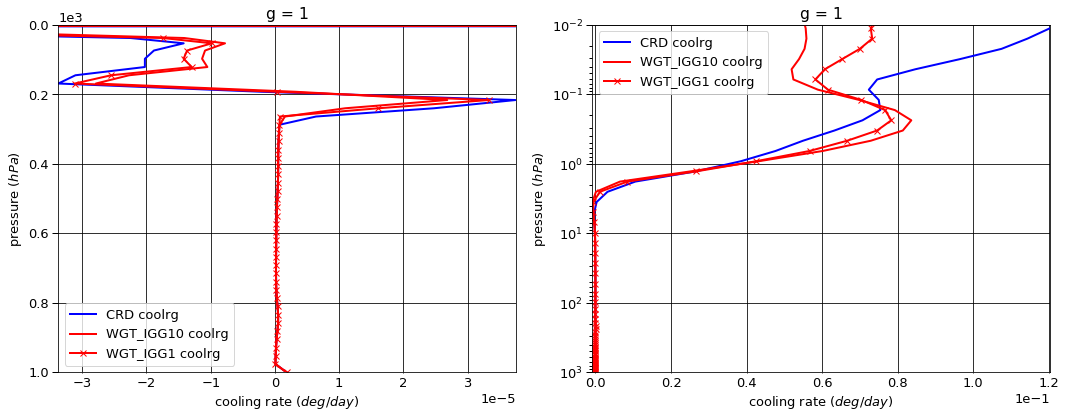

# Figure: cooling rate g-group 2

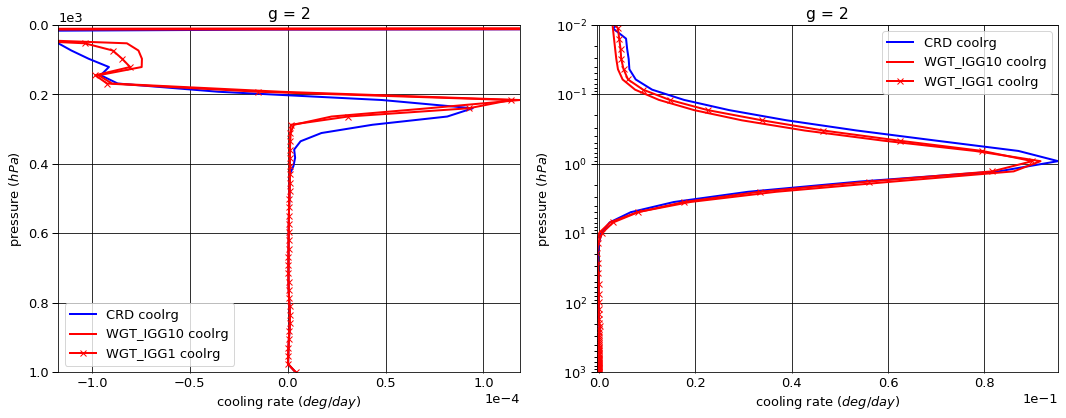

# Figure: cooling rate g-group 3

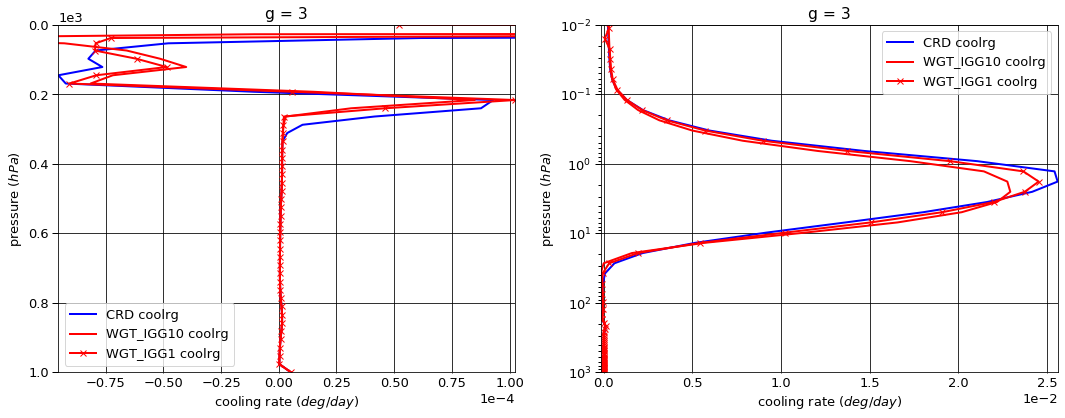

# Figure: cooling rate g-group 4

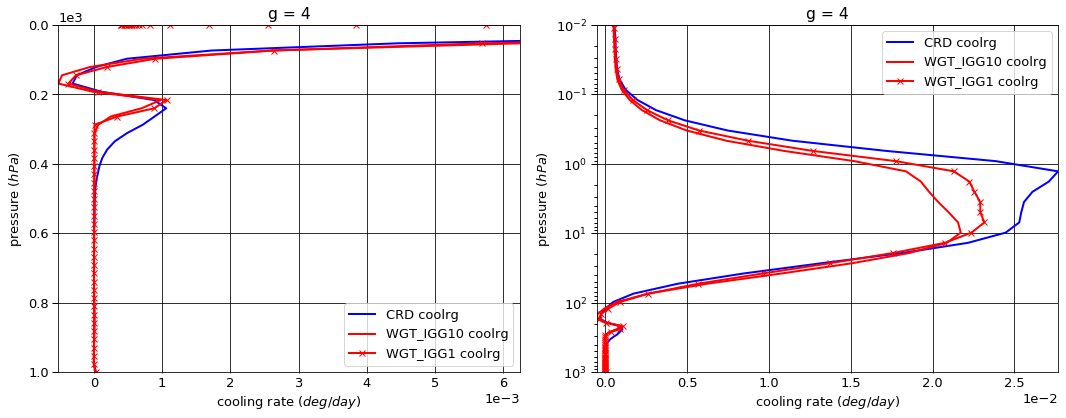

# Figure: cooling rate g-group 5

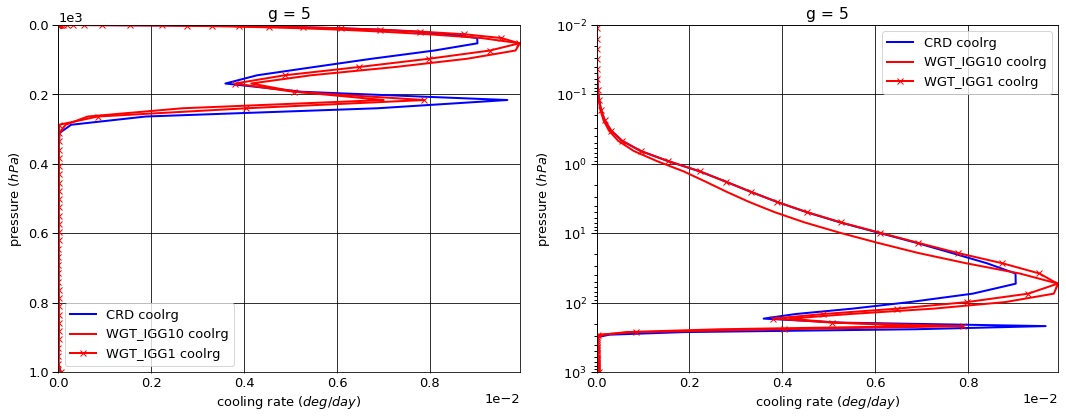

# Figure: cooling rate g-group 6

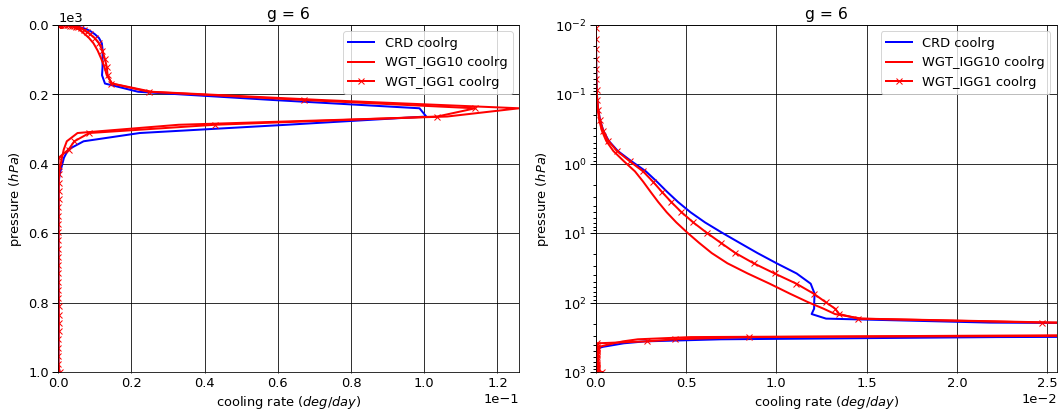

# Figure: cooling rate g-group 7

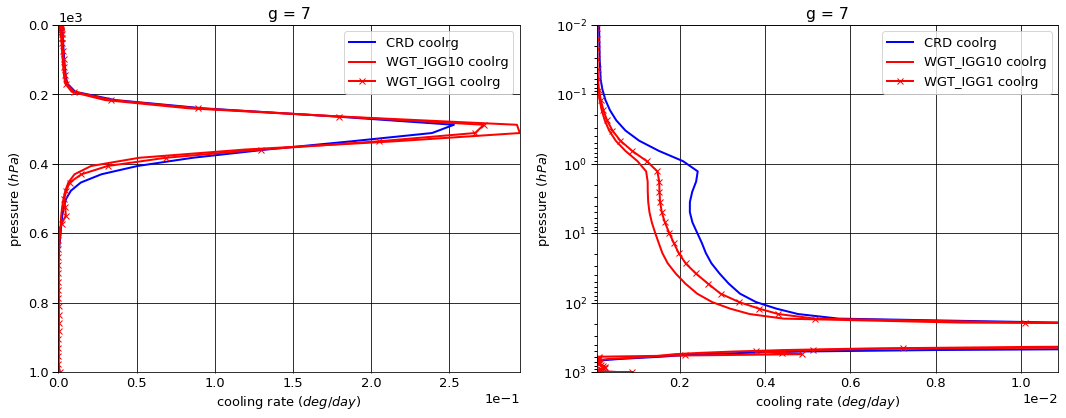

# Figure: cooling rate g-group 8

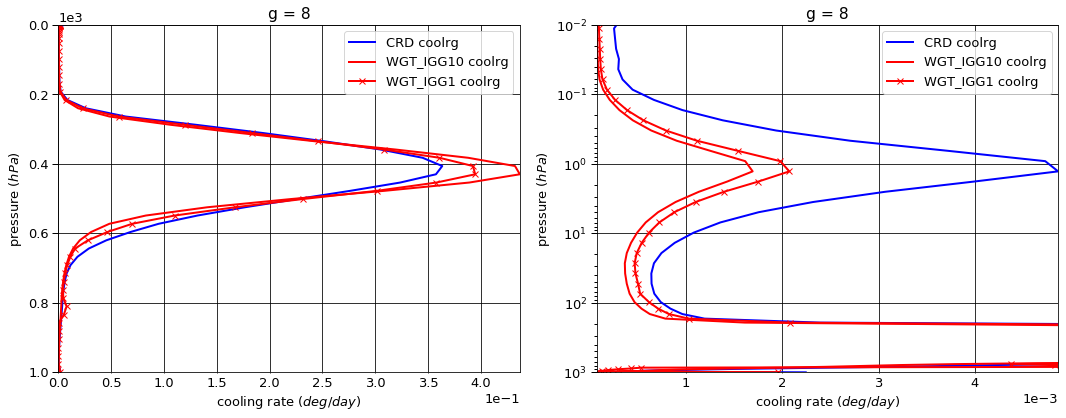

# Figure: cooling rate g-group 9

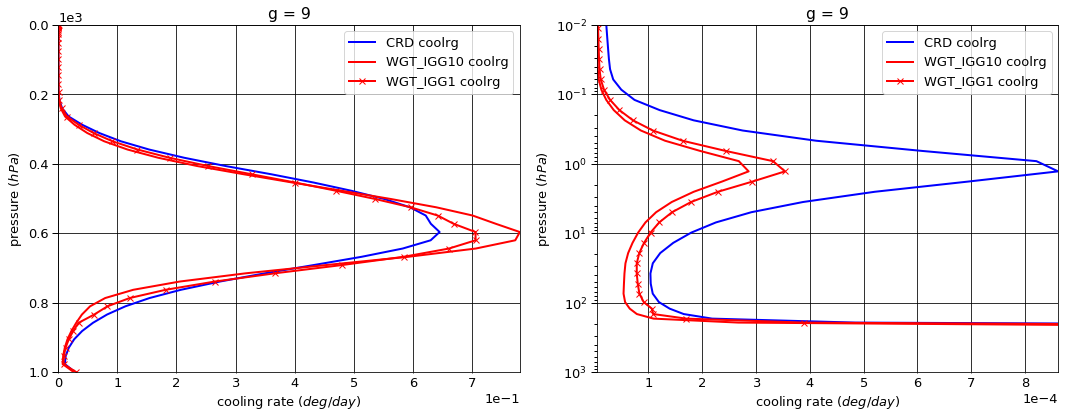

# Figure: cooling rate g-group 10

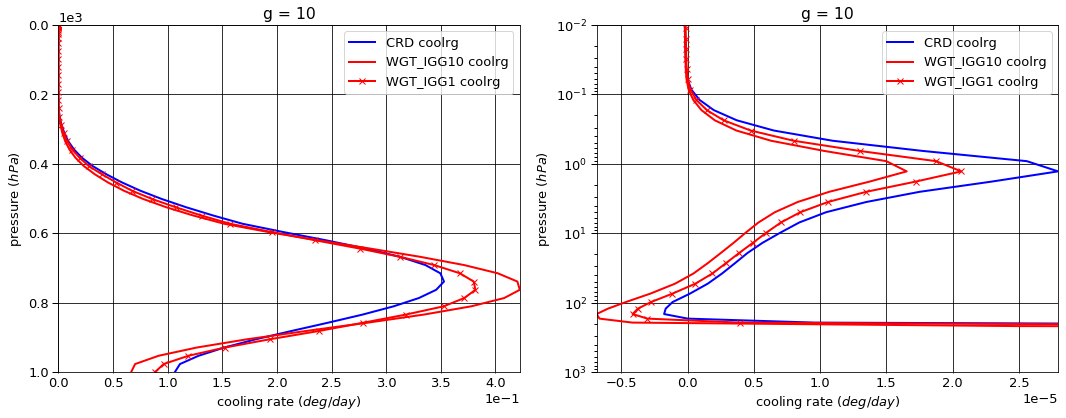

# Figure: cooling rate g-group total

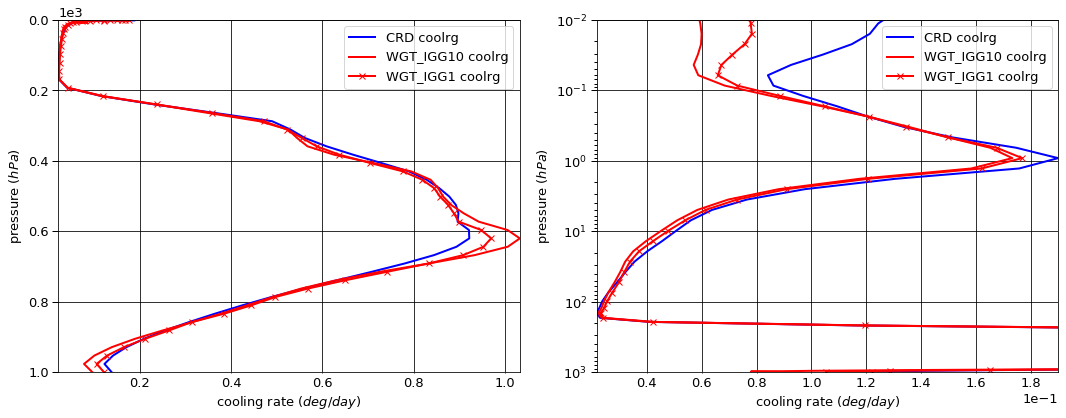

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.008991   0.000000  -0.008991
   1013.0   76     -0.014010   0.014005  -0.000005
2  0.0      1      -0.022543   0.000000  -0.022543
   1013.0   76     -0.030830   0.030819  -0.000011
3  0.0      1      -0.025582   0.000000  -0.025582
   1013.0   76     -0.040348   0.040333  -0.000015
4  0.0      1      -0.114171   0.000000  -0.114171
   1013.0   76     -0.216556   0.216478  -0.000079
5  0.0      1      -0.205255   0.000000  -0.205255
   1013.0   76     -0.427088   0.426939  -0.000149
6  0.0      1      -1.309624   0.000000  -1.309624
   1013.0   76     -2.591219   2.590278  -0.000942
7  0.0      1      -3.843442   0.000000  -3.843442
   1013.0   76     -6.672580   6.670157  -0.002423
8  0.0      1      -9.849801   0.000000  -9.849801
   1013.0   76    -14.741030  14.735109  -0.005920
9  0.0      1     -24.757567   0.000000 -24.757567
   1013.0   76    -32.218456  32.134886  -0.083571
10 0.0      1     -15.701261   0.000000 -15.701261
   1013.0   76    -18.305375  17.442015  -0.863361


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.009038   0.000000  -0.009038
   1013.0   76     -0.014010   0.014005  -0.000005
2  0.0      1      -0.022974   0.000000  -0.022974
   1013.0   76     -0.030830   0.030819  -0.000011
3  0.0      1      -0.025754   0.000000  -0.025754
   1013.0   76     -0.040348   0.040333  -0.000015
4  0.0      1      -0.110438   0.000000  -0.110438
   1013.0   76     -0.216556   0.216478  -0.000079
5  0.0      1      -0.201843   0.000000  -0.201843
   1013.0   76     -0.427088   0.426939  -0.000149
6  0.0      1      -1.288517   0.000000  -1.288517
   1013.0   76     -2.591219   2.590278  -0.000942
7  0.0      1      -3.815989   0.000000  -3.815989
   1013.0   76     -6.672580   6.670157  -0.002423
8  0.0      1      -9.806630   0.000000  -9.806630
   1013.0   76    -14.741030  14.735613  -0.005416
9  0.0      1     -24.788721   0.000000 -24.788721
   1013.0   76    -32.218456  32.148394  -0.070062
10 0.0      1     -15.682319   0.000000 -15.682319
   1013.0   76    -18.305375  18.032537  -0.272839


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.009044   0.000000  -0.009044
   1013.0   76     -0.014010   0.014005  -0.000005
2  0.0      1      -0.022686   0.000000  -0.022686
   1013.0   76     -0.030830   0.030819  -0.000011
3  0.0      1      -0.025720   0.000000  -0.025720
   1013.0   76     -0.040348   0.040333  -0.000015
4  0.0      1      -0.110899   0.000000  -0.110899
   1013.0   76     -0.216556   0.216478  -0.000079
5  0.0      1      -0.203126   0.000000  -0.203126
   1013.0   76     -0.427088   0.426939  -0.000149
6  0.0      1      -1.291655   0.000000  -1.291655
   1013.0   76     -2.591219   2.590278  -0.000942
7  0.0      1      -3.821677   0.000000  -3.821677
   1013.0   76     -6.672580   6.670157  -0.002423
8  0.0      1      -9.822971   0.000000  -9.822971
   1013.0   76    -14.741030  14.735613  -0.005416
9  0.0      1     -24.810858   0.000000 -24.810858
   1013.0   76    -32.218456  32.135417  -0.083039
10 0.0      1     -15.685293   0.000000 -15.685293
   1013.0   76    -18.305375  17.881532  -0.423843


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -4.723780e-05  0.000000e+00 -4.723780e-05
   1013.0   76     1.734723e-18  0.000000e+00  0.000000e+00
2  0.0      1     -4.311450e-04  0.000000e+00 -4.311450e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1     -1.721540e-04  0.000000e+00 -1.721540e-04
   1013.0   76     0.000000e+00  6.938894e-18 -1.694066e-21
4  0.0      1      3.732760e-03  0.000000e+00  3.732760e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1      3.411730e-03  0.000000e+00  3.411730e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6  0.0      1      2.110630e-02  0.000000e+00  2.110630e-02
   1013.0   76     0.000000e+00  0.000000e+00 -1.084202e-19
7  0.0      1      2.745300e-02  0.000000e+00  2.745300e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      4.317080e-02  0.000000e+00  4.317080e-02
   1013.0   76    -1.776357e-15  5.040000e-04  5.040019e-04
9  0.0      1     -3.115400e-02  0.000000e+00 -3.115400e-02
   1013.0   76     0.000000e+00  1.350800e-02  1.350846e-02
10 0.0      1      1.894200e-02  0.000000e+00  1.894200e-02
   1013.0   76     0.000000e+00  5.905220e-01  5.905223e-01


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -5.337090e-05  0.000000e+00 -5.337090e-05
   1013.0   76     1.734723e-18  0.000000e+00  0.000000e+00
2  0.0      1     -1.428050e-04  0.000000e+00 -1.428050e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1     -1.380660e-04  0.000000e+00 -1.380660e-04
   1013.0   76     0.000000e+00  6.938894e-18 -1.694066e-21
4  0.0      1      3.272380e-03  0.000000e+00  3.272380e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1      2.129120e-03  0.000000e+00  2.129120e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6  0.0      1      1.796840e-02  0.000000e+00  1.796840e-02
   1013.0   76     0.000000e+00  0.000000e+00 -1.084202e-19
7  0.0      1      2.176500e-02  0.000000e+00  2.176500e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      2.682970e-02  0.000000e+00  2.682970e-02
   1013.0   76    -1.776357e-15  5.040000e-04  5.040021e-04
9  0.0      1     -5.329100e-02  0.000000e+00 -5.329100e-02
   1013.0   76     0.000000e+00  5.310000e-04  5.312860e-04
10 0.0      1      1.596800e-02  0.000000e+00  1.596800e-02
   1013.0   76     0.000000e+00  4.395170e-01  4.395174e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.199312e-01
   1001.112500 75     1.807280e-06
2  0.000312    1      3.443615e-03
   1001.112500 75     4.088893e-06
3  0.000312    1      1.141252e-04
   1001.112500 75     5.264319e-06
4  0.000312    1      3.787094e-04
   1001.112500 75     2.836986e-05
5  0.000312    1      6.026816e-08
   1001.112500 75     5.391388e-05
6  0.000312    1      5.621754e-06
   1001.112500 75     3.400707e-04
7  0.000312    1      7.896157e-05
   1001.112500 75     8.750991e-04
8  0.000312    1      1.724367e-04
   1001.112500 75     2.242722e-03
9  0.000312    1      1.182625e-05
   1001.112500 75     2.870789e-02
10 0.000312    1     -3.491971e-07
   1001.112500 75     1.065205e-01


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      4.426565e-02
   1001.112500 75     1.807280e-06
2  0.000312    1      1.216968e-03
   1001.112500 75     4.088893e-06
3  0.000312    1      1.663141e-04
   1001.112500 75     5.264319e-06
4  0.000312    1      3.705539e-04
   1001.112500 75     2.836986e-05
5  0.000312    1      5.339687e-08
   1001.112500 75     5.391388e-05
6  0.000312    1      4.383777e-06
   1001.112500 75     3.400707e-04
7  0.000312    1      3.430446e-05
   1001.112500 75     8.750991e-04
8  0.000312    1      4.400478e-05
   1001.112500 75     1.970763e-03
9  0.000312    1      4.278745e-07
   1001.112500 75     2.663612e-02
10 0.000312    1     -2.690306e-07
   1001.112500 75     6.652461e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      6.650416e-02
   1001.112500 75     1.807280e-06
2  0.000312    1      2.630175e-03
   1001.112500 75     4.088893e-06
3  0.000312    1      1.645380e-04
   1001.112500 75     5.264319e-06
4  0.000312    1      3.962581e-04
   1001.112500 75     2.836986e-05
5  0.000312    1      6.188439e-08
   1001.112500 75     5.391388e-05
6  0.000312    1      5.386905e-06
   1001.112500 75     3.400707e-04
7  0.000312    1      4.413117e-05
   1001.112500 75     8.750991e-04
8  0.000312    1      6.178408e-05
   1001.112500 75     1.956285e-03
9  0.000312    1      2.343463e-06
   1001.112500 75     3.053065e-02
10 0.000312    1     -2.463592e-07
   1001.112500 75     8.820856e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -7.566553e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -2.226647e-03
   1001.112500 75     0.000000e+00
3  0.000312    1      5.218891e-05
   1001.112500 75     0.000000e+00
4  0.000312    1     -8.155490e-06
   1001.112500 75     3.388132e-21
5  0.000312    1     -6.871290e-09
   1001.112500 75     6.776264e-21
6  0.000312    1     -1.237977e-06
   1001.112500 75     0.000000e+00
7  0.000312    1     -4.465712e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.284319e-04
   1001.112500 75    -2.719586e-04
9  0.000312    1     -1.139838e-05
   1001.112500 75    -2.071774e-03
10 0.000312    1      8.016642e-08
   1001.112500 75    -3.999590e-02


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.342702e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -8.134392e-04
   1001.112500 75     0.000000e+00
3  0.000312    1      5.041276e-05
   1001.112500 75     0.000000e+00
4  0.000312    1      1.754873e-05
   1001.112500 75     3.388132e-21
5  0.000312    1      1.616222e-09
   1001.112500 75     6.776264e-21
6  0.000312    1     -2.348494e-07
   1001.112500 75     0.000000e+00
7  0.000312    1     -3.483040e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.106526e-04
   1001.112500 75    -2.864365e-04
9  0.000312    1     -9.482789e-06
   1001.112500 75     1.822759e-03
10 0.000312    1      1.028378e-07
   1001.112500 75    -1.831195e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-55.838236,0.000000,-55.838236
1013.0,76,-75.257492,74.301018,-0.956475



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-55.752224,0.000000,-55.752224
1013.0,76,-75.257492,74.905552,-0.351940



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-55.803929,0.00000,-55.803929
1013.0,76,-75.257492,74.74157,-0.515922



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,8.601205e-02,0.000000,0.086012
1013.0,76,-1.421085e-14,0.604534,0.604535



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.430736e-02,0.000000,0.034307
1013.0,76,-1.421085e-14,0.440552,0.440553


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.124136
1001.112500,75,0.138780



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.046102
1001.112500,75,0.096440



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.069809
1001.112500,75,0.122004



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.078034
1001.112500,75,-0.042340



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.054328
1001.112500,75,-0.016776


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000194,0.000191
2,0.000417,0.000415
3,0.000556,0.000548
4,0.002972,0.002934
5,0.006028,0.005876
6,0.035472,0.035078
7,0.091500,0.090356
8,0.200694,0.198606
9,0.430083,0.429875


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.207420e-18
2,4.515983e-19
3,3.585786e-19
4,4.018118e-20
5,8.769537e-20
6,1.186674e-20
7,1.605781e-21
8,2.172908e-22
9,2.940331e-23


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.207420e-18,NaN,0.000194,0.000191,0.000194,0.000191,1.0
2,4.515983e-19,0.107334,0.000417,0.000415,0.000611,0.000606,1.0
3,3.585786e-19,0.794021,0.000556,0.000548,0.001167,0.001154,10.0
4,4.018118e-20,0.112057,0.002972,0.002934,0.004139,0.004088,10.0
5,8.769537e-20,2.182498,0.006028,0.005876,0.010167,0.009964,500.0
6,1.186674e-20,0.135318,0.035472,0.035078,0.045639,0.045042,500.0
7,1.605781e-21,0.135318,0.091500,0.090356,0.137139,0.135398,500.0
8,2.172908e-22,0.135318,0.200694,0.198606,0.337833,0.334004,500.0
9,2.940331e-23,0.135318,0.430083,0.429875,0.767917,0.763879,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     1.374966e-17  6.885358e-18   1.996942  8.201938e-04
      2  0.000312     5.396177e-19  3.361064e-19   1.605496  3.555571e-05
      3  0.000312     1.335608e-20  1.221785e-20   1.093161  1.079259e-06
      4  0.000312     3.988865e-21  2.393760e-21   1.666359  2.581917e-07
      5  0.000312     1.809408e-25  1.809406e-25   1.000001  1.540912e-11
      6  0.000312     3.020999e-24  2.800446e-24   1.078756  2.460022e-10
      7  0.000312     2.197864e-23  4.627777e-24   4.749287  9.851545e-10
      8  0.000312     2.841597e-23  1.079206e-24  26.330436  1.023118e-09
      9  0.000312     2.052958e-24  1.061353e-25  19.342840  7.535607e-11
      10 0.000312     7.289333e-26  1.449973e-26   5.027219  4.715820e-12
2     1  0.000750     1.377100e-17  6.896971e-18   1.996674  3.308950e-04
      2  0.000750     5.432960e-19  3.386221e-19   1.604432  1.442361e-05
      3  0.000750     1.351457e-20  1.235859e-20   1.093536  4.397825e-07
      4  0.000750     4.025611e-21  2.412486e-21   1.668657  1.048858e-07
      5  0.000750     4.348612e-25  4.348603e-25   1.000002  1.491649e-11
      6  0.000750     3.095792e-24  2.871947e-24   1.077942  1.015842e-10
      7  0.000750     2.208436e-23  4.656890e-24   4.742299  3.988569e-10
      8  0.000750     2.858588e-23  1.083225e-24  26.389600  4.145125e-10
      9  0.000750     2.063021e-24  1.066158e-25  19.350051  3.050037e-11
      10 0.000750     7.348580e-26  1.458238e-26   5.039355  1.914546e-12
3     1  0.001052     1.381740e-17  6.921771e-18   1.996223  4.656509e-04
      2  0.001052     5.511320e-19  3.439200e-19   1.602500  2.053115e-05
      3  0.001052     1.381580e-20  1.262082e-20   1.094683  6.301093e-07
      4  0.001052     4.099511e-21  2.447751e-21   1.674807  1.495301e-07
      5  0.001052     6.149189e-25  6.149171e-25   1.000003  2.958020e-11
      6  0.001052     3.181818e-24  2.951245e-24   1.078127  1.464042e-10
      7  0.001052     2.230198e-23  4.709689e-24   4.735340  5.650625e-10
      8  0.001052     2.894987e-23  1.090676e-24  26.543049  5.885252e-10
      9  0.001052     2.084576e-24  1.075382e-25  19.384509  4.321467e-11
      10 0.001052     7.474536e-26  1.474261e-26   5.070021  2.729657e-12
4     1  0.001476     1.386621e-17  6.948043e-18   1.995699  6.556391e-04
      2  0.001476     5.595662e-19  3.496221e-19   1.600489  2.926155e-05
      3  0.001476     1.414758e-20  1.291004e-20   1.095859  9.046424e-07
      4  0.001476     4.180146e-21  2.486333e-21   1.681249  2.135135e-07
      5  0.001476     8.701429e-25  8.701393e-25   1.000004  5.872159e-11
      6  0.001476     3.286721e-24  3.048940e-24   1.077988  2.121769e-10
      7  0.001476     2.253669e-23  4.767495e-24   4.727155  8.013978e-10
      8  0.001476     2.934070e-23  1.098840e-24  26.701520  8.365180e-10
      9  0.001476     2.107799e-24  1.085389e-25  19.419762  6.129292e-11
      10 0.001476     7.610984e-26  1.491499e-26   5.102909  3.897361e-12
5     1  0.002070     1.391461e-17  6.974345e-18   1.995114  9.229174e-04
      2  0.002070     5.681592e-19  3.554371e-19   1.598480  4.169745e-05
      3  0.002070     1.449736e-20  1.321591e-20   1.096963  1.299454e-06
      4  0.002070     4.263908e-21  2.526760e-21   1.687500  3.049385e-07
      5  0.002070     1.231478e-24  1.231471e-24   1.000006  1.165637e-10
      6  0.002070     3.413891e-24  3.168709e-24   1.077376  3.092133e-10
      7  0.002070     2.277707e-23  4.828323e-24   4.717387  1.136586e-09
      8  0.002070     2.973767e-23  1.107420e-24  26.853116  1.188806e-09
      9  0.002070     2.131477e-24  1.095760e-25  19.452035  8.692402e-11
      10 0.002070     7.751007e-26  1.509203e-26   5.135828  5.564191e-12
6     1  0.002904     1.396245e-17  7.000634e-18   1.994455  1.299246e-03
      2  0.002904     5.769122e-19  3.613730e-19   1.596445  5.942834e-05
      3  0.002904     1.486980e

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
